In [1]:
import os, json
from tqdm import tqdm
import torch
from pytorch_msssim import ssim

import cv2

device="cuda"

def calculate_ssim_values(folder):
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(".png") and not f.lower().endswith(".mask.png")]

    results = {}
    
    for img_name in tqdm(image_files, desc="Processing images", unit="img"):
        base_name, ext = os.path.splitext(img_name)

        json_path = os.path.join(folder, f"{base_name}.json")
        if not os.path.exists(json_path):
            print(f"Skipping {img_name}: no matching JSON {base_name}.json found.")
            continue

        with open(json_path, "r") as f:
            data = json.load(f)

        image_path = os.path.join(folder, img_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Failed to load image: {image_path}")
            continue

        sourceImage = data.get("sourceImage", "")
        variant = data.get("variant", "")

        if not results.get(variant):
            results[variant] = []

        template = cv2.imread(f'p_Templates/{sourceImage}')
        template.resize((1024,1024,3))

        image_tensor = torch.from_numpy(image).float().permute(2, 0, 1).unsqueeze(0).to(device) / 255.0
        template_tensor = torch.from_numpy(template).float().permute(2, 0, 1).unsqueeze(0).to(device) / 255.0

        with torch.no_grad():
            score = ssim(
                template_tensor,
                image_tensor,
                data_range=1.0,
                size_average=True
            ).item()

        del image_tensor
        del template_tensor
        torch.cuda.empty_cache()

        results[variant].append(score)

    return results

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
base_results = calculate_ssim_values("p_BaseImages")
variants_results = calculate_ssim_values("p_VariantImages")
occlusion_results = calculate_ssim_values("p_VariantImagesWithOcclusion")

Processing images: 100%|██████████| 19494/19494 [19:45<00:00, 16.44img/s]  


In [3]:
base_results, variants_results, occlusion_results

({'snow': [0.3370250463485718,
   0.4183638095855713,
   0.4643608033657074,
   0.4292151629924774,
   0.08853191137313843,
   0.250541090965271,
   0.16432425379753113,
   0.4482061564922333,
   0.3368796110153198,
   0.11134451627731323,
   0.595457911491394,
   0.5473012328147888,
   0.19529426097869873,
   0.3410641551017761,
   0.4459792375564575,
   0.6029919385910034,
   0.29206979274749756,
   0.14156492054462433,
   0.34827905893325806,
   0.05766567215323448,
   0.2931276559829712,
   0.1567326784133911,
   0.3003757894039154,
   0.3504984378814697,
   0.5089830160140991,
   0.433586061000824,
   0.32654231786727905,
   0.08322130888700485,
   0.6815909147262573,
   0.5375193953514099,
   0.4690922200679779,
   0.2553425133228302,
   0.1516399085521698,
   0.41888970136642456,
   0.4905303716659546,
   0.1338571310043335,
   0.22982260584831238,
   0.45331764221191406,
   0.3674187660217285,
   0.20509099960327148,
   0.40406736731529236,
   0.3357042968273163,
   0.284852474

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def summarize_results(results_dict):
    summary = {}
    for variant, scores in results_dict.items():
        summary[variant] = {
            "mean": np.mean(scores),
            "std": np.std(scores),
            "min": np.min(scores),
            "max": np.max(scores)
        }
    return summary

base_summary = summarize_results(base_results)
variant_summary = summarize_results(variants_results)
occlusion_summary = summarize_results(occlusion_results)


In [5]:
base_summary

{'snow': {'mean': 0.3235963026262882,
  'std': 0.1662383060778531,
  'min': 0.013790149241685867,
  'max': 0.7049330472946167},
 'night': {'mean': 0.10010712384671963,
  'std': 0.054619397383418714,
  'min': 0.011103610508143902,
  'max': 0.3337647318840027},
 'rain': {'mean': 0.1888480869552683,
  'std': 0.09645738605081632,
  'min': 0.018328387290239334,
  'max': 0.4588117003440857},
 'dawn': {'mean': 0.27990361339208825,
  'std': 0.1506093091009245,
  'min': 0.017057692632079124,
  'max': 0.6327332258224487},
 'fog+night': {'mean': 0.1658929046810994,
  'std': 0.09551025223223325,
  'min': 0.023780126124620438,
  'max': 0.5195314288139343},
 'day': {'mean': 0.28825408466149977,
  'std': 0.1513165703317817,
  'min': 0.013528148643672466,
  'max': 0.657099187374115},
 'dusk': {'mean': 0.2587519396313175,
  'std': 0.1382724122825606,
  'min': 0.020395638421177864,
  'max': 0.5633112788200378},
 'snow+night': {'mean': 0.14864996799791536,
  'std': 0.08352723050699394,
  'min': 0.0094015

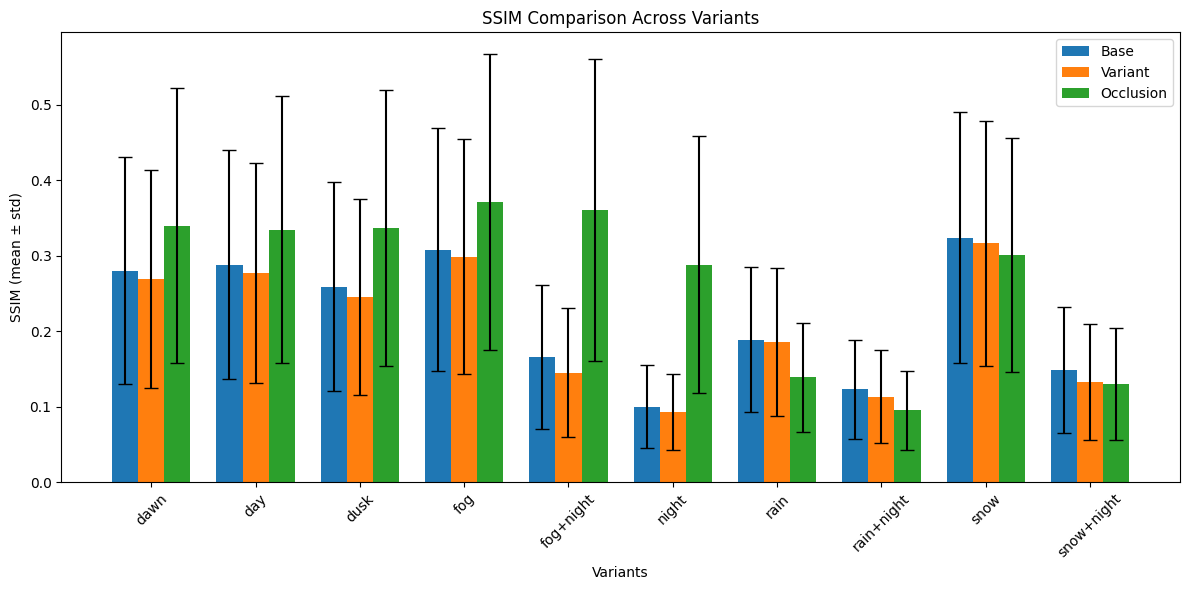

In [9]:
def plot_ssim_summary(*summaries, labels):
    variants = sorted(set().union(*[s.keys() for s in summaries]))

    x = np.arange(len(variants))
    width = 0.25  # Width of each bar

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, (summary, label) in enumerate(zip(summaries, labels)):
        means = [summary.get(v, {}).get("mean", 0) for v in variants]
        stds = [summary.get(v, {}).get("std", 0) for v in variants]
        ax.bar(x + i * width, means, width, yerr=stds, label=label, capsize=5)

    ax.set_xlabel("Variants")
    ax.set_ylabel("SSIM (mean ± std)")
    ax.set_title("SSIM Comparison Across Variants")
    ax.set_xticks(x + width)
    ax.set_xticklabels(variants, rotation=45)
    ax.legend()
    plt.tight_layout()
    plt.savefig("SSIM.png")
    plt.show()

plot_ssim_summary(base_summary, variant_summary, occlusion_summary,
                  labels=["Base", "Variant", "Occlusion"])


/tmp/ipykernel_265278/2663051345.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[i].boxplot(data, labels=labels, showfliers=False)
/tmp/ipykernel_265278/2663051345.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[i].boxplot(data, labels=labels, showfliers=False)
/tmp/ipykernel_265278/2663051345.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[i].boxplot(data, labels=labels, showfliers=False)
/tmp/ipykernel_265278/2663051345.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  a

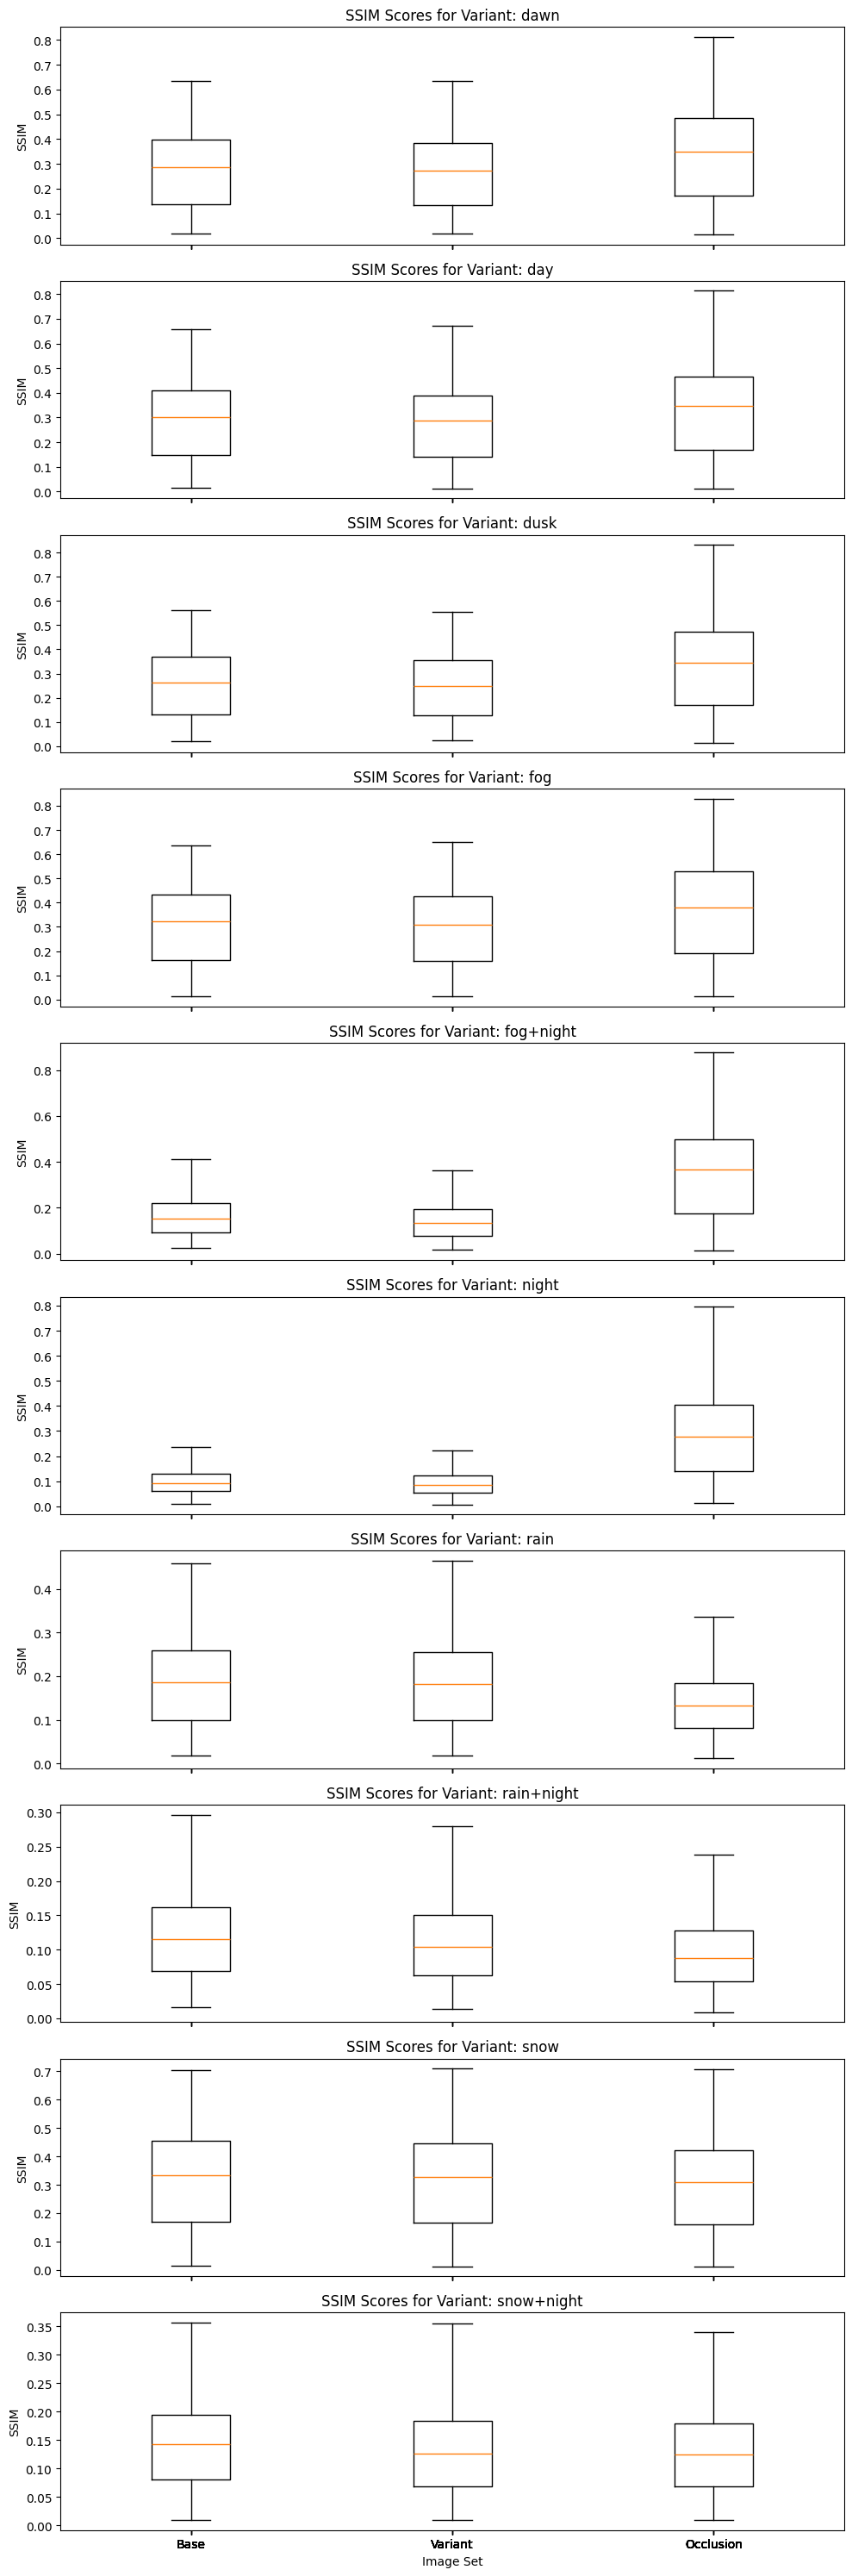

In [7]:
def plot_ssim_boxplot(results_dicts, labels):
    variants = sorted(set().union(*[d.keys() for d in results_dicts]))

    fig, ax = plt.subplots(len(variants), 1, figsize=(10, len(variants) * 3), sharex=True)

    for i, variant in enumerate(variants):
        data = [d.get(variant, []) for d in results_dicts]
        ax[i].boxplot(data, labels=labels, showfliers=False)
        ax[i].set_title(f"SSIM Scores for Variant: {variant}")
        ax[i].set_ylabel("SSIM")

    plt.xlabel("Image Set")
    plt.tight_layout()
    plt.show()

plot_ssim_boxplot([base_results, variants_results, occlusion_results],
                  labels=["Base", "Variant", "Occlusion"])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.860170128506559..0.9902567360888651].


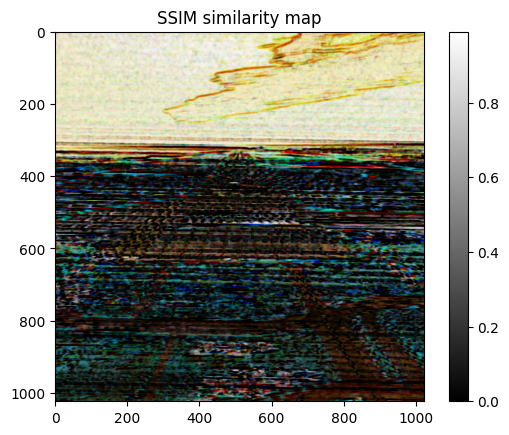

0.3356076100085428

In [62]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

img_original = cv2.imread('p_Templates/0CLSYZPFbTg_110.png')
img_original.resize((1024,1024, 3))
img_synthetic = cv2.imread('p_BaseImages/0CLSYZPFbTg_110__day_3.png')

score, ssim_map = calculate_ssim(img_original,img_synthetic)
# result["snow"][0][1]

plt.imshow(ssim_map, cmap='gray')
plt.colorbar()
plt.title("SSIM similarity map")
plt.show()
score